In [95]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: nvidia-smi: command not found
time: 143 ms (started: 2022-02-15 07:17:05 +00:00)


# Libraries

In [96]:
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.45 s (started: 2022-02-15 07:17:07 +00:00)


In [97]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
time: 1.59 ms (started: 2022-02-15 07:17:11 +00:00)


In [98]:
!pip install --quiet optuna

time: 3.65 s (started: 2022-02-15 07:17:11 +00:00)


In [99]:
import os
import pandas as pd
import numpy as np
import time
import datetime
import itertools
import glob
import re
from tqdm import tqdm
import gc

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')

from skimage import io
from PIL import Image
import cv2
import collections
from skimage import filters
from skimage import util
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import MeanShift, estimate_bandwidth
from skimage.transform import resize

from sklearn.model_selection import train_test_split


from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider
from ipywidgets import BoundedIntText,FloatSlider
import ipywidgets as widgets
from sklearn.cluster import MiniBatchKMeans
import numpy as np
from skimage.exposure import histogram
from skimage import img_as_float
from skimage.segmentation import watershed
from skimage.segmentation import mark_boundaries
from sklearn.cluster import spectral_clustering
import sklearn.feature_extraction
from skimage.color import rgb2gray
from skimage.filters import sobel

time: 28 ms (started: 2022-02-15 07:17:14 +00:00)


# Variables

## Paths

In [100]:
root_dir ='/content/drive/MyDrive/@Projet datascientest/'
raw_data_dir = root_dir + 'RAW DATA/'
DL_dir = root_dir + 'DEEP LEARNING/' 

# export dir with time satmp
timestamp = datetime.datetime.now().strftime('%y%m%d_%HH%M')
export_dir = DL_dir + timestamp + '/'
os.makedirs(export_dir)
print(str(export_dir))

/content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/220215_07H17/
time: 14.2 ms (started: 2022-02-15 07:17:14 +00:00)


## Other

In [101]:
# seed
random_seed = 42

#ZIP file with images 
raw_data_folder = 'RAW DATA.zip'
raw_data_folder = 'RAW DATA FOR DEBUG.zip' # pour aller plus vite sur unzip 1400 images only 
# df with file_path 
csv_file_paths = 'image_and_json_data_DEBUG.csv' if raw_data_folder == 'RAW DATA FOR DEBUG.zip' else 'image_and_json_data.csv'


# resolution des images apres redimmensionnement (/!\ inversé par rapport à scikit)
resol = (240, 320) # (240, 320), [(24 , 32),(48 , 64),(72 , 96)]
# number of class to keep 
family_number = 7 # 7 pour comparaison Xgboost (acc = 0.32) & random 1/7 = 0.14
number_of_images = 1000  # None to get all images 
add_FRUIT360_images = False #add a class with 6000 images of 131 classes of fruit if true (kaggle dataset - 45 random images/class)


# DEBUG 
debug = False
one_image_per_class_only = False  # HARD DEBUG TO SEE if CNN learn
# epochs
number_of_images = 1000 if debug else number_of_images
family_number = 3 if debug else family_number 


time: 10.2 ms (started: 2022-02-15 07:17:14 +00:00)


# Load & filter data

## Unzip images

In [102]:
# unzipping the file into the VM disk is SO much faster than reading each file individually from Drive
# cf https://stackoverflow.com/questions/59120853/google-colab-is-so-slow-while-reading-images-from-google-drive
main_path = "/content/"  + raw_data_folder.replace('.zip','') 
if os.path.exists(main_path)== False :
  if csv_file_paths == 'image_and_json_data_DEBUG.csv':
    !unzip '/content/drive/MyDrive/@Projet datascientest/RAW DATA FOR DEBUG.zip' -d "/content"
  elif csv_file_paths == 'image_and_json_data.csv':
    !unzip '/content/drive/MyDrive/@Projet datascientest/RAW DATA.zip' -d "/content"
else:
  print('ZIP already extracted')

ZIP already extracted
time: 6.92 ms (started: 2022-02-15 07:17:14 +00:00)


In [103]:
#FRUIT360 dataset pour créer un dataset sans champigons 
main_path = "/content/FRUIT360"
if os.path.exists(main_path)== False :
  if add_FRUIT360_images:
    !unzip '/content/drive/MyDrive/@Projet datascientest/FRUIT360.zip' -d "/content"

time: 2.97 ms (started: 2022-02-15 07:17:14 +00:00)


## File_path df

In [104]:
# df with path & target 
df_paths = pd.read_csv(root_dir + csv_file_paths)
print('{} rows in the file'.format(len(df_paths)))
df_paths .head()

1480 rows in the file


,Unnamed: 0,file_name,file_path,resolution,file_year,image_id,format,observation,label,image_url,user,date,thumbnail,location,gbif_info.kingdom,gbif_info.family,gbif_info.speciesKey,gbif_info.rank,gbif_info.phylum,gbif_info.orderKey,gbif_info.species,gbif_info.confidence,gbif_info.classKey,gbif_info.matchType,gbif_info.familyKey,gbif_info.status,gbif_info.usageKey,gbif_info.kingdomKey,gbif_info.genusKey,gbif_info.canonicalName,gbif_info.phylumKey,gbif_info.class,gbif_info.synonym,gbif_info.scientificName,gbif_info.genus,gbif_info.order,gbif_info.note,gbif_info,json_file,new_path,train_test
0,1381,6746.jpg,C:/Users/thibe/Google Drive/@Projet datascient...,"(320, 240)",2007,6746,jpg,4278,Agaricus bernardi,http://mushroomobserver.org/images/320/6746,1,2007-10-07 04:40:35,1,2.0,Fungi,Agaricaceae,5243392.0,SPECIES,Basidiomycota,1499.0,Agaricus bernardii,94.0,186.0,FUZZY,4170.0,ACCEPTED,5243392.0,5.0,7893259.0,Agaricus bernardii,34.0,Agaricomycetes,False,"Agaricus bernardii Quél., 1878",Agaricus,Agaricales,NaN,NaN,observations_0.json,C:/Users/thibe/Google Drive/@Projet datascient...,Training
1,338,507.jpg,C:/Users/thibe/Google Drive/@Projet datascient...,"(320, 240)",2006,507,jpg,408,Coprinellus micaceus,http://mushroomobserver.org/images/320/507,1,2006-05-21 07:30:22,1,28.0,Fungi,Psathyrellaceae,2534578.0,SPECIES,Basidiomycota,1499.0,Coprinellus micaceus,98.0,186.0,EXACT,4184.0,ACCEPTED,2534578.0,5.0,2534558.0,Coprinellus micaceus,34.0,Agaricomycetes,False,"Coprinellus micaceus (Bull.) Vilgalys, Hopple ...",Coprinellus,Agaricales,NaN,NaN,observations_0.json,C:/Users/thibe/Google Drive/@Projet datascient...,Training
2,1875,4009.jpg,C:/Users/thibe/Google Drive/@Projet datascient...,"(320, 240)",2007,4009,jpg,2915,Boletus edulis var. grandedulis,http://mushroomobserver.org/images/320/4009,123,2007-03-27 06:57:29,1,183.0,Fungi,Boletaceae,5954958.0,VARIETY,Basidiomycota,1063.0,Boletus edulis,98.0,186.0,EXACT,8789.0,SYNONYM,6015477.0,5.0,7241486.0,Boletus edulis grandedulis,34.0,Agaricomycetes,True,Boletus edulis var. grandedulis Arora & Simoni...,Boletus,Boletales,NaN,NaN,observations_0.json,C:/Users/thibe/Google Drive/@Projet datascient...,Training
3,4632,8992.jpg,C:/Users/thibe/Google Drive/@Projet datascient...,"(320, 240)",2007,8992,jpg,5288,Suillus pungens,http://mushroomobserver.org/images/320/8992,2,2007-12-02 06:16:20,1,10.0,Fungi,Suillaceae,5239898.0,SPECIES,Basidiomycota,1063.0,Suillus pungens,98.0,186.0,EXACT,8455.0,ACCEPTED,5239898.0,5.0,7396347.0,Suillus pungens,34.0,Agaricomycetes,False,"Suillus pungens Thiers & A.H. Sm., 1964",Suillus,Boletales,NaN,NaN,observations_0.json,C:/Users/thibe/Google Drive/@Projet datascient...,Training
4,137,855.jpg,C:/Users/thibe/Google Drive/@Projet datascient...,"(320, 240)",2006,855,jpg,718,Amanita phalloides,http://mushroomobserver.org/images/320/855,2,2006-09-30 22:32:28,1,10.0,Fungi,Amanitaceae,5240325.0,SPECIES,Basidiomycota,1499.0,Amanita phalloides,97.0,186.0,EXACT,4171.0,ACCEPTED,5240325.0,5.0,2526057.0,Amanita phalloides,34.0,Agaricomycetes,False,"Amanita phalloides (Vaill. ex Fr.) Link, 1833",Amanita,Agaricales,NaN,NaN,observations_0.json,C:/Users/thibe/Google Drive/@Projet datascient...,Training


time: 118 ms (started: 2022-02-15 07:17:14 +00:00)


In [105]:
# FRUIT360
if add_FRUIT360_images:
  # Trouver tous les chemins vers les fichiers qui finissent par .jpg
  liste = glob.glob('/content/FRUIT360/*/*.jpg')
  # Remplacer les \\ par /
  liste = list(map(lambda x : [x, x.split('/')[2]], liste))
  # Créer un DataFrame pandas
  df_FRUIT360  = pd.DataFrame(liste, columns=['drive_file_path', 'gbif_info.family'])
  display(df_FRUIT360.head())

time: 6.33 ms (started: 2022-02-15 07:17:15 +00:00)


In [106]:
# adjust paths for drive 
# SPECIFIC DRIVE lo laod image from content 
df_paths['drive_file_path'] =df_paths['file_path'].apply(lambda x: x.replace('C:/Users/thibe/Google Drive/@Projet datascientest',
                                              '/content')).apply(lambda x: x.replace('C:/Users/thibe/Google Drive/Projet datascientest',
                                              '/content')) # pas propre, remplacer par regex + re à l'occas 
df_paths['drive_file_path'] =df_paths['drive_file_path'].apply(lambda x: x.replace('\\','/'))
df_paths['drive_file_path']

0       /content/RAW DATA FOR DEBUG/Training/Agaricace...
1       /content/RAW DATA FOR DEBUG/Training/Psathyrel...
2       /content/RAW DATA FOR DEBUG/Training/Boletacea...
3       /content/RAW DATA FOR DEBUG/Training/Suillacea...
4       /content/RAW DATA FOR DEBUG/Training/Amanitace...
                              ...                        
1475    /content/RAW DATA FOR DEBUG/Testing/Stropharia...
1476    /content/RAW DATA FOR DEBUG/Testing/Boletaceae...
1477    /content/RAW DATA FOR DEBUG/Testing/Suillaceae...
1478    /content/RAW DATA FOR DEBUG/Testing/Russulacea...
1479    /content/RAW DATA FOR DEBUG/Testing/Russulacea...
Name: drive_file_path, Length: 1480, dtype: object

time: 14.8 ms (started: 2022-02-15 07:17:15 +00:00)


In [107]:
#select only 320,240 images with family info
df_paths = df_paths[df_paths['resolution']=='(320, 240)'] 

time: 8.92 ms (started: 2022-02-15 07:17:15 +00:00)


In [108]:
# drop na 
df_paths = df_paths[df_paths['gbif_info.family'].notna()]

time: 5.76 ms (started: 2022-02-15 07:17:15 +00:00)


In [109]:
# keep conf level over 90 
df_paths = df_paths.loc[df_paths['gbif_info.confidence']>90]

time: 5.45 ms (started: 2022-02-15 07:17:15 +00:00)


In [110]:
# keep only most common class
top_class = df_paths['gbif_info.class'].value_counts().index[0]
df_paths = df_paths[df_paths['gbif_info.class'] == top_class]
df_paths['gbif_info.class'].value_counts()

Agaricomycetes    1480
Name: gbif_info.class, dtype: int64

time: 12.3 ms (started: 2022-02-15 07:17:15 +00:00)


In [111]:
# Check number of classes 
pd.DataFrame(df_paths.groupby(['gbif_info.family'], as_index=False).size())

,gbif_info.family,size
0,Agaricaceae,224
1,Amanitaceae,194
2,Boletaceae,138
3,Cortinariaceae,99
4,Inocybaceae,82
5,Psathyrellaceae,100
6,Russulaceae,226
7,Strophariaceae,153
8,Suillaceae,97
9,Tricholomataceae,167


time: 17.7 ms (started: 2022-02-15 07:17:15 +00:00)


In [112]:
# keep only top families 
top_fam = df_paths['gbif_info.family'].value_counts().index[:family_number].values
df_paths = df_paths[df_paths['gbif_info.family'].isin(top_fam)]

time: 6.58 ms (started: 2022-02-15 07:17:15 +00:00)


In [113]:
# reduce number or images if needed 
if number_of_images != None and not one_image_per_class_only: 
  df_paths,_ = train_test_split(df_paths,train_size=number_of_images,stratify=df_paths['gbif_info.family'],random_state=random_seed )
  print('{} rows in the file'.format(len(df_paths)))

1000 rows in the file
time: 11.1 ms (started: 2022-02-15 07:17:15 +00:00)


In [114]:
summary = df_paths.copy() #copy for later 
# summary.info()

time: 2.94 ms (started: 2022-02-15 07:17:15 +00:00)


In [115]:
# subset col of interest + label encoding
df = df_paths[['drive_file_path','gbif_info.family']].copy()
df['label'] = df['gbif_info.family'].replace(df['gbif_info.family'].unique(), [*range(len(df['gbif_info.family'].unique()))]).astype(str) # label encoding 

df.head()

,drive_file_path,gbif_info.family,label
40,/content/RAW DATA FOR DEBUG/Training/Russulace...,Russulaceae,0
337,/content/RAW DATA FOR DEBUG/Training/Boletacea...,Boletaceae,1
202,/content/RAW DATA FOR DEBUG/Training/Russulace...,Russulaceae,0
1191,/content/RAW DATA FOR DEBUG/Testing/Psathyrell...,Psathyrellaceae,2
230,/content/RAW DATA FOR DEBUG/Training/Strophari...,Strophariaceae,3


time: 24.8 ms (started: 2022-02-15 07:17:15 +00:00)


In [116]:
# concat with FRUIT360 
if add_FRUIT360_images:
  df_FRUIT360['label'] = df['label'].max() + 1 
  df = pd.concat([df,df_FRUIT360]).reset_index(drop=True)

time: 2.72 ms (started: 2022-02-15 07:17:15 +00:00)


In [117]:
# compute number of classes
print('number of rows = {}'.format(len(df['label'])))
dict_label_df = pd.DataFrame(df.groupby(['label','gbif_info.family'], as_index=False).size())
classes_count = len(dict_label_df)
dict_label_df

number of rows = 1000


,label,gbif_info.family,size
0,0,Russulaceae,188
1,1,Boletaceae,115
2,2,Psathyrellaceae,83
3,3,Strophariaceae,127
4,4,Amanitaceae,162
5,5,Tricholomataceae,139
6,6,Agaricaceae,186


time: 23.9 ms (started: 2022-02-15 07:17:15 +00:00)


In [118]:
# CREATE DICT LABELS 
dict_label = dict(dict_label_df[['label','gbif_info.family']].values)
dict_label

{'0': 'Russulaceae',
 '1': 'Boletaceae',
 '2': 'Psathyrellaceae',
 '3': 'Strophariaceae',
 '4': 'Amanitaceae',
 '5': 'Tricholomataceae',
 '6': 'Agaricaceae'}

time: 7.84 ms (started: 2022-02-15 07:17:15 +00:00)


## Train/test split

In [119]:
#train/test 
# Train/test
df_train, df_test= train_test_split(df, train_size=0.8, stratify =df['label'], random_state=random_seed)
# train / val 
df_train_, df_val_= train_test_split(df_train, train_size=0.8, stratify =df_train['label'], random_state=random_seed)
print(df_train_.shape,df_val_.shape,df_test.shape)

(640, 3) (160, 3) (200, 3)
time: 16.4 ms (started: 2022-02-15 07:17:15 +00:00)


### Plot few images

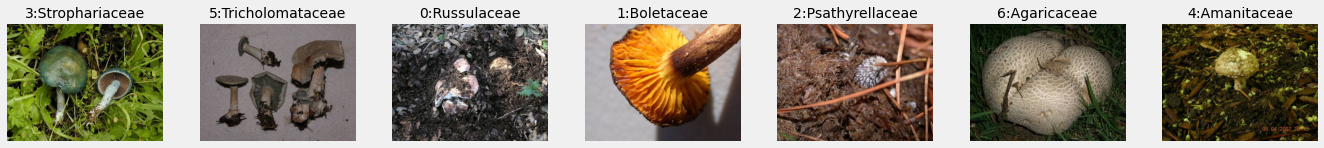

time: 555 ms (started: 2022-02-15 07:17:15 +00:00)


In [120]:
# first od each cat to check train/test
im_to_plot = df_train.groupby('label').head(1)
# plot
fig = plt.figure(figsize=(3*family_number,2))
j = 1 
for idx in im_to_plot.index:
  col_number = family_number
  row_number = 1
  ax = plt.subplot(row_number,col_number,j)
  im = io.imread(im_to_plot.loc[idx,'drive_file_path'])
  plt.imshow(im)
  label = str(im_to_plot.loc[idx,'label']) + ':' + dict_label[str(im_to_plot.loc[idx,'label'])]
  plt.title(label,size = 14)
  plt.axis('off')
  j +=1
fig.savefig(export_dir + str(resol) + '_first image of each family.jpeg' );

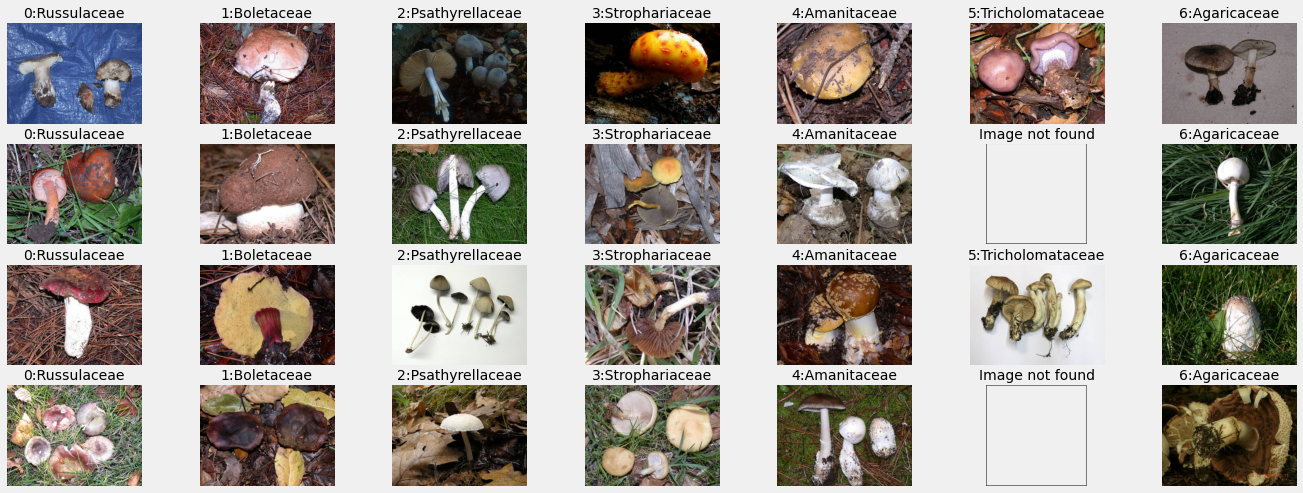

time: 3.03 s (started: 2022-02-15 07:17:15 +00:00)


In [121]:
# Plot random images de X_train (im_per_class per class)
im_per_class = 5 
#generate df with n image per class train set 
dfs_ = []
for n in range(im_per_class-1):
  df_ = df_train.groupby('label').apply(lambda x: x.sample(1))
  df_ = df_.droplevel(level=0)
  dfs_.append(df_)
im_to_plot = pd.concat(dfs_)
# plot
fig = plt.figure(figsize=(3*family_number,2*im_per_class))
j = 1 
for idx in im_to_plot.index:
  try:
    col_number = family_number
    row_number = im_per_class
    ax = plt.subplot(row_number,col_number,j)
    im = io.imread(im_to_plot.loc[idx,'drive_file_path'])
    plt.imshow(im)
    label = str(im_to_plot.loc[idx,'label']) + ':' + dict_label[str(im_to_plot.loc[idx,'label'])]
    plt.title(label,size = 14)
    plt.axis('off')
  except:
    im = io.imread('https://upload.wikimedia.org/wikipedia/commons/thumb/1/1f/Blank_square.svg/600px-Blank_square.svg.png')
    plt.imshow(im)
    label = 'Image not found'
    plt.title(label,size = 14)
    plt.axis('off')
  j +=1
fig.savefig(export_dir + str(resol) + '_family examples.jpeg' );

# Segmentation

* https://stackoverflow.com/questions/46392904/scikit-mean-shift-algorithm-returns-black-picture
* https://medium.com/@muhammetbolat/image-segmentation-using-k-means-clustering-algorithm-and-mean-shift-clustering-algorithm-fb6ebe4cb761

## Kmeans

* https://analyticsindiamag.com/beginners-guide-to-image-compression-using-k-means-clustering/#:~:text=Beginners%20Guide%20to%20Image%20Compression%20using%20K%2DMeans%20Clustering,-By%20Himanshu%20Sharma&text=Image%20compression%20is%20reducing%20the,low%20quality%20takes%20less%20memory.


In [122]:
# define image
i = 5 #5 
resize_factor = 5 #5 
image_path = df_train.iloc[i]['drive_file_path'] 

time: 3.11 ms (started: 2022-02-15 07:17:18 +00:00)


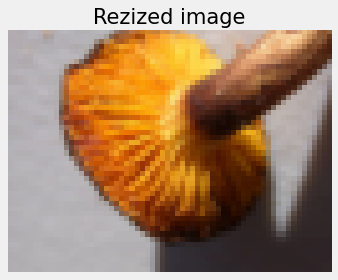

time: 126 ms (started: 2022-02-15 07:17:18 +00:00)


In [123]:
#Loading original image
originImg = io.imread(image_path)# ploat original image 
imageName = image_path
image = plt.imread(imageName)
image = resize(image,(int(image.shape[0]/resize_factor), int(image.shape[1]/resize_factor)))
plt.figure(dpi=75)
plt.title('Rezized image')
plt.axis('off')
plt.imshow(image)

In [124]:
# dfs from images 
index = pd.MultiIndex.from_product(
    (*map(range, image.shape[:2]), ('r', 'g', 'b')),
    names=('row', 'col', None))
df_5_feat = pd.Series(image.flatten(), index=index)
df_5_feat = df_5_feat.unstack()
df_5_feat = df_5_feat.reset_index().reindex(columns=['col','row',   'r','g','b'])
df_3_feat = df_5_feat[['r','g','b']]

time: 18.5 ms (started: 2022-02-15 07:17:19 +00:00)


In [125]:
#normalisation 
scaler_3d = MinMaxScaler(feature_range = (0,1))
nd_3_feat = scaler_3d.fit_transform(df_3_feat)

scaler_5d = MinMaxScaler(feature_range = (0,1))
nd_5_feat = scaler_5d.fit_transform(df_5_feat)

time: 15.7 ms (started: 2022-02-15 07:17:19 +00:00)


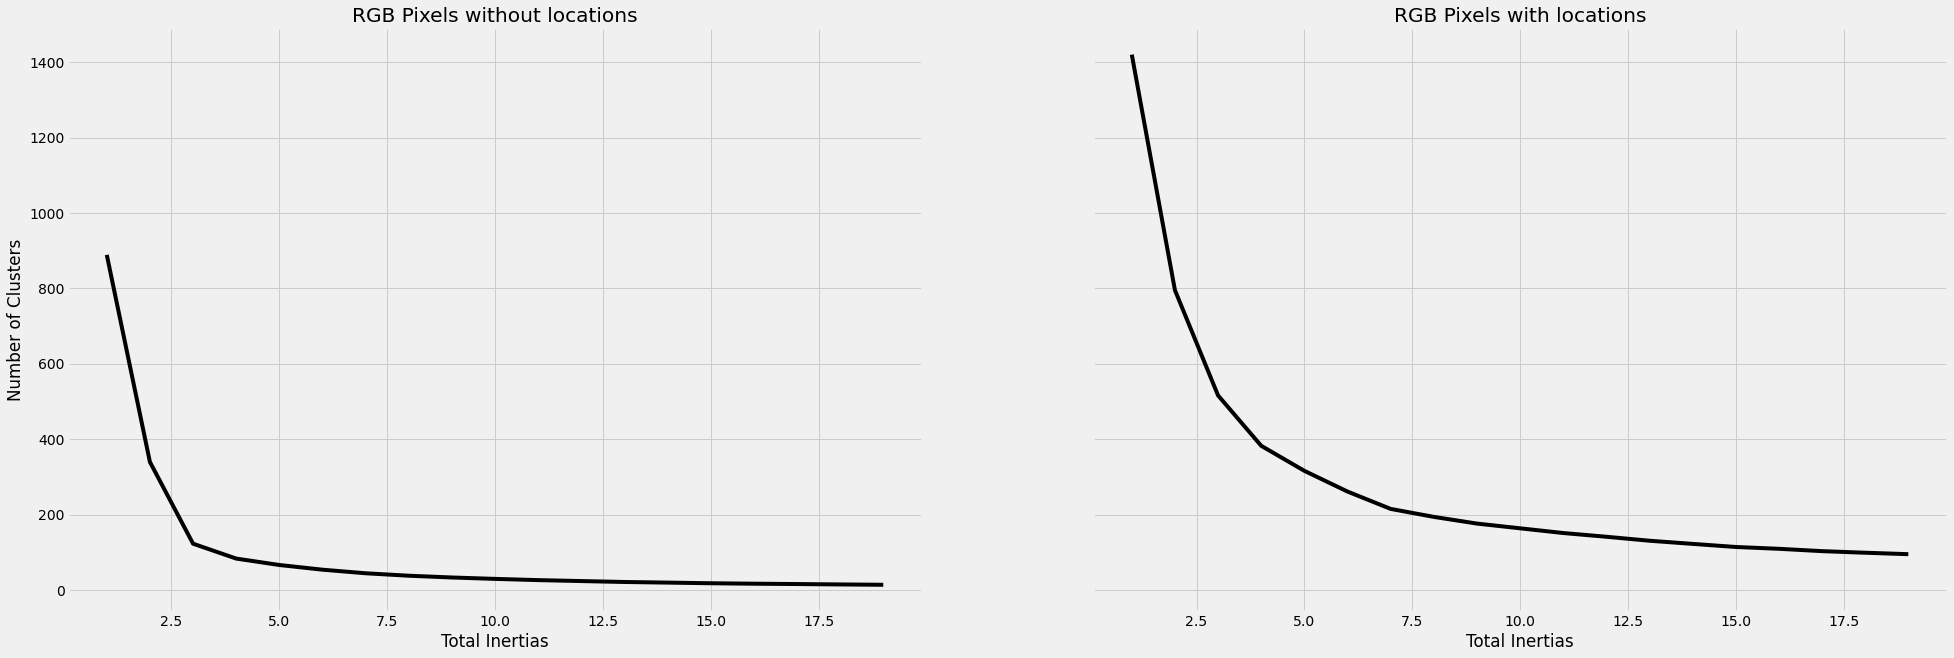

time: 3min 30s (started: 2022-02-15 07:17:19 +00:00)


In [126]:
# find K 
total_inertias_1 = [KMeans(n_clusters=i).fit(nd_3_feat).inertia_ for i in range(1, 20)]
total_inertias_2 = [KMeans(n_clusters=i).fit(nd_5_feat).inertia_ for i in range(1, 20)]
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(30,10))
ax1.plot(range(1, 20), total_inertias_1, c='black')
ax1.set(xlabel='Total Inertias', ylabel='Number of Clusters', title='RGB Pixels without locations')
ax2.plot(range(1, 20), total_inertias_2, c='black')
ax2.set(xlabel='Total Inertias', title='RGB Pixels with locations');

In [127]:
# final fit 
km_3_feat = KMeans(n_clusters=3).fit(nd_3_feat) #3 for im 5
km_5_feat = KMeans(n_clusters=7).fit(nd_5_feat) #7 for im 5

time: 2.62 s (started: 2022-02-15 07:20:50 +00:00)


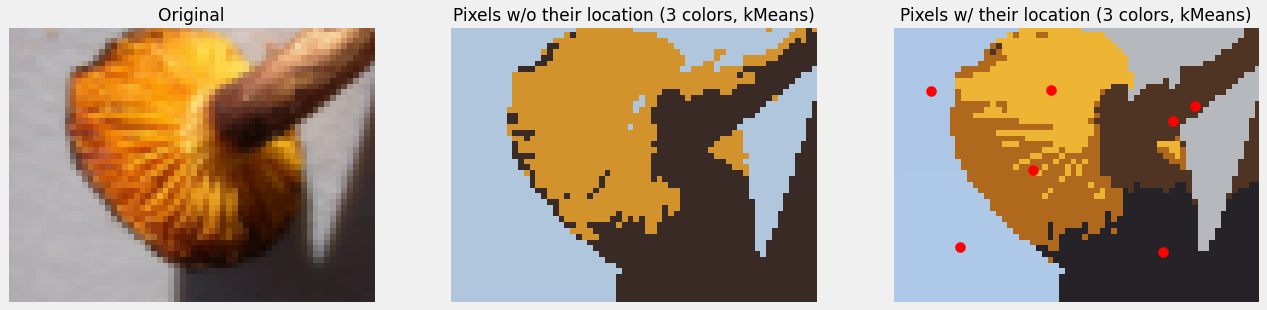

time: 247 ms (started: 2022-02-15 07:20:52 +00:00)


In [128]:
#Using K value to create clusters
km_colors_3_feat = km_3_feat.cluster_centers_[km_3_feat.predict(nd_3_feat)]
km_colors_5_feat = km_5_feat.cluster_centers_[km_5_feat.predict(nd_5_feat)]
# Reshaping the image according to the clusters
k_img_3_feat = np.reshape(km_colors_3_feat, (image.shape))
k_img_5_feat = np.reshape(km_colors_5_feat[:,2:5], (image.shape))

#Plotting the compressed and original image
fig, (ax1,ax2,ax3) = plt.subplots(1, 3,figsize=(20,5))
# fig.suptitle('K-means Image Compressor', fontsize=20)
ax1.set_title('Original', fontsize=17)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.imshow(image)
ax2.set_title('Pixels w/o their location ({} colors, kMeans)'.format(len(km_3_feat.cluster_centers_)), fontsize=17)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.imshow(k_img_3_feat)
ax3.set_title('Pixels w/ their location ({} colors, kMeans)'.format(len(km_3_feat.cluster_centers_)), fontsize=17)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.imshow(k_img_5_feat)
plt.scatter(scaler_5d.inverse_transform(km_5_feat.cluster_centers_)[:, 0], scaler_5d.inverse_transform(km_5_feat.cluster_centers_)[:, 1], s=100, c='r')
plt.subplots_adjust(top=0.85)
plt.show()

### Interactive widget k selector 
 * from https://analyticsindiamag.com/beginners-guide-to-image-compression-using-k-means-clustering/#:~:text=Beginners%20Guide%20to%20Image%20Compression%20using%20K%2DMeans%20Clustering,-By%20Himanshu%20Sharma&text=Image%20compression%20is%20reducing%20the,low%20quality%20takes%20less%20memory.


In [ ]:
@interact
#defining compression function
def compression(
                i = BoundedIntText(min=1, max=len(df_train),step=1,value=45,  continuous_update=False,  
                                         description='image number',layout=dict(width='10%')),
                resize_factor = IntSlider(min=1, max=10,step=1,value=5,  continuous_update=False, 
                                         description='resize factor',layout=dict(width='25%')),
                k_3_feat=IntSlider(min=1, max=30,step=1,value=2,  continuous_update=False, 
                                         layout=dict(width='50%')),
                k_5_feat=IntSlider(min=1, max=30,step=1,value=5,  continuous_update=False, 
                                         layout=dict(width='50%'))
                ):
    # define image 
    # i = 5 #5 
    # resize_factor = 5 #5 
    image_path = df_train.iloc[i]['drive_file_path'] 
    # load image 
    image = plt.imread(image_path)
    image = resize(image,(int(image.shape[0]/resize_factor), int(image.shape[1]/resize_factor)))
    # dfs from images 
    index = pd.MultiIndex.from_product(
        (*map(range, image.shape[:2]), ('r', 'g', 'b')),
        names=('row', 'col', None))
    df_5_feat = pd.Series(image.flatten(), index=index)
    df_5_feat = df_5_feat.unstack()
    df_5_feat = df_5_feat.reset_index().reindex(columns=['col','row',   'r','g','b'])
    df_3_feat = df_5_feat[['r','g','b']]
    #normalisation 
    scaler_3d = MinMaxScaler(feature_range = (0,1))
    nd_3_feat = scaler_3d.fit_transform(df_3_feat)
    scaler_5d = MinMaxScaler(feature_range = (0,1))
    nd_5_feat = scaler_5d.fit_transform(df_5_feat)
    #Using K value to create clusters
    km_3_feat = MiniBatchKMeans(k_3_feat).fit(nd_3_feat)
    km_colors_3_feat = km_3_feat.cluster_centers_[km_3_feat.predict(nd_3_feat)]
    km_5_feat = MiniBatchKMeans(k_5_feat).fit(nd_5_feat)
    km_colors_5_feat = km_5_feat.cluster_centers_[km_5_feat.predict(nd_5_feat)]
    # Reshaping the image according to the clusters
    k_img_3_feat = np.reshape(km_colors_3_feat, (image.shape))
    k_img_5_feat = np.reshape(km_colors_5_feat[:,2:5], (image.shape))
    #Plotting the compressed and original image
    plt.clf()
    fig1, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(20,10))
    ax1.set_title('Original \n quality divided by {}'.format(resize_factor), fontsize=17)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.imshow(image)
    ax2.set_title('Pixels w/o their location \n ({} colors, MiniBatchKMeans)'.format(len(km_3_feat.cluster_centers_)), fontsize=17)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.imshow(k_img_3_feat)
    ax3.set_title('Pixels w/ their location \n ({} colors, MiniBatchKMeans)'.format(len(km_5_feat.cluster_centers_)), fontsize=17)
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.imshow(k_img_5_feat)
    plt.scatter(scaler_5d.inverse_transform(km_5_feat.cluster_centers_)[:, 0], scaler_5d.inverse_transform(km_5_feat.cluster_centers_)[:, 1], s=100, c='r')
    plt.subplots_adjust(top=0.85)
    display(fig1);
    # plt.close()
    # find K 
    plt.clf()
    total_inertias_1 = [MiniBatchKMeans(n_clusters=i).fit(nd_3_feat).inertia_ for i in range(1, 20)]
    total_inertias_2 = [MiniBatchKMeans(n_clusters=i).fit(nd_5_feat).inertia_ for i in range(1, 20)]
    fig2, (ax1, ax2) = plt.subplots(1, 2, sharex='col', sharey='row',figsize=(20,5)) #  figsize=(5,10)
    ax1.plot(range(1, 20), total_inertias_1, c='black') 
    ax1.set(xlabel='Total Inertias', ylabel='Number of Clusters', title='RGB Pixels without locations')
    ax1.axvline(x= k_3_feat,c='r')
    ax2.plot(range(1, 20), total_inertias_2, c='black')
    ax2.set(xlabel='Total Inertias', title='RGB Pixels with locations')
    ax2.axvline(x= k_5_feat,c='r')
    plt.show();

interactive(children=(BoundedIntText(value=45, description='image number', layout=Layout(width='10%'), max=800…

## Mean shift 

* https://medium.com/@muhammetbolat/image-segmentation-using-k-means-clustering-algorithm-and-mean-shift-clustering-algorithm-fb6ebe4cb761

In [ ]:
@interact
#defining compression function
def meanshift_compression(
                i = BoundedIntText(min=1, max=len(df_train),step=1,value=45,  continuous_update=False,  
                                         description='image number',layout=dict(width='10%')),
                resize_factor = IntSlider(min=1, max=10,step=1,value=5,  continuous_update=False, 
                                         description='resize factor',layout=dict(width='25%')),
                bandwidth_3_feat=FloatSlider(min=0.01, max=1,step=0.01,value=0.2,  continuous_update=False, 
                                         layout=dict(width='50%')),
                bandwidth_5_feat=FloatSlider(min=0.01, max=1,step=0.01,value=0.3,  continuous_update=False, 
                                         layout=dict(width='50%'))
              
                ):
  # define image 
  # i = 5 #5 
  # resize_factor = 5 #5 
  image_path = df_train.iloc[i]['drive_file_path'] 
  # load image 
  image = plt.imread(image_path)
  image = resize(image,(int(image.shape[0]/resize_factor), int(image.shape[1]/resize_factor)))
  # dfs from images 
  index = pd.MultiIndex.from_product(
      (*map(range, image.shape[:2]), ('r', 'g', 'b')),
      names=('row', 'col', None))
  df_5_feat = pd.Series(image.flatten(), index=index)
  df_5_feat = df_5_feat.unstack()
  df_5_feat = df_5_feat.reset_index().reindex(columns=['col','row',   'r','g','b'])
  df_3_feat = df_5_feat[['r','g','b']]
  #normalisation 
  scaler_3d = MinMaxScaler(feature_range = (0,1))
  nd_3_feat = scaler_3d.fit_transform(df_3_feat)
  scaler_5d = MinMaxScaler(feature_range = (0,1))
  nd_5_feat = scaler_5d.fit_transform(df_5_feat)
  # mean shift fit 
  sug_bandwidth_3_feat = round(estimate_bandwidth(nd_3_feat, quantile=.1, n_jobs=-1),2)
  sug_bandwidth_5_feat = round(estimate_bandwidth(nd_5_feat, quantile=.1, n_jobs=-1),2)
  print('suggested settings using estimate_bandwidth fonction = {} / {}'.format(sug_bandwidth_3_feat,sug_bandwidth_5_feat))
  ms_3_feat = MeanShift(bandwidth = bandwidth_3_feat, n_jobs=-1, bin_seeding=True, cluster_all=True).fit(nd_3_feat)
  ms_5_feat = MeanShift(bandwidth = bandwidth_5_feat , n_jobs=-1, bin_seeding=True, cluster_all=True).fit(nd_5_feat)
  #Using N clusters value to create clusters
  ms_colors_3_feat = ms_3_feat.cluster_centers_[ms_3_feat.predict(nd_3_feat)]
  ms_colors_5_feat = ms_5_feat .cluster_centers_[ms_5_feat .predict(nd_5_feat)]
  # Reshaping the image according to the clusters
  ms_img_3_feat = np.reshape(ms_colors_3_feat, (image.shape))
  ms_img_5_feat = np.reshape(ms_colors_5_feat[:,2:5], (image.shape))
  #Plotting the compressed and original image
  plt.clf()
  fig1, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(20,10))
  ax1.set_title('Original \n quality divided by {}'.format(resize_factor), fontsize=17)
  ax1.set_xticks([])
  ax1.set_yticks([])
  ax1.imshow(image)
  ax2.set_title('Pixels w/o their location \n ({} colors, MeanShift)'.format(len(ms_3_feat.cluster_centers_)), fontsize=17)
  ax2.set_xticks([])
  ax2.set_yticks([])
  ax2.imshow(ms_img_3_feat)
  ax3.set_title('Pixels w/ their location \n ({} colors, MeanShift)'.format(len(ms_5_feat.cluster_centers_)), fontsize=17)
  ax3.set_xticks([])
  ax3.set_yticks([])
  ax3.imshow(ms_img_5_feat)
  plt.scatter(scaler_5d.inverse_transform(ms_5_feat.cluster_centers_)[:, 0], scaler_5d.inverse_transform(ms_5_feat.cluster_centers_)[:, 1], s=100, c='r')
  plt.subplots_adjust(top=0.85)
  plt.show();

## Spectral_clustering

* https://scikit-learn.org/stable/auto_examples/cluster/plot_coin_segmentation.html#sphx-glr-auto-examples-cluster-plot-coin-segmentation-py

In [ ]:
i = 45 #5 
resize_factor = 5 #5 
image_path = df_train.iloc[i]['drive_file_path'] 
# load image 
image = io.imread(image_path)
image = rgb2gray(image)
image = resize(image, (int(image.shape[0]/resize_factor), int(image.shape[1]/resize_factor)))

In [ ]:
graph = sklearn.feature_extraction.image.img_to_graph(image)

# Take a decreasing function of the gradient: an exponential
# The smaller beta is, the more independent the segmentation is of the
# actual image. For beta=1, the segmentation is close to a voronoi
beta = 10
eps = 1e-6
graph.data = np.exp(-beta * graph.data / graph.data.std()) + eps

# Apply spectral clustering (this step goes much faster if you have pyamg
# installed)
N_REGIONS = 25

In [ ]:
for assign_labels in ("kmeans", "discretize"):
    t0 = time.time()
    labels = spectral_clustering(
        graph, n_clusters=N_REGIONS, assign_labels=assign_labels, random_state=42
    )
    t1 = time.time()
    labels = labels.reshape(image.shape)

    plt.figure(figsize=(5, 5))
    plt.imshow(image, cmap=plt.cm.gray)
    for l in range(N_REGIONS):
        plt.contour(labels == l, colors=[plt.cm.nipy_spectral(l / float(N_REGIONS))])
    plt.xticks(())
    plt.yticks(())
    title = "Spectral clustering: %s, %.2fs" % (assign_labels, (t1 - t0))
    print(title)
    plt.title(title)
plt.show()

## Edge detection

* https://scikit-image.org/docs/stable/auto_examples/applications/plot_coins_segmentation.html

In [ ]:
# 
i = 45 #5 
resize_factor = 5 #5 
image_path = df_train.iloc[i]['drive_file_path'] 
# load image 
image = io.imread(image_path)
image = rgb2gray(image)
image = resize(image, (int(image.shape[0]/resize_factor), int(image.shape[1]/resize_factor)))
edge_roberts = filters.roberts(image)
edge_sobel = filters.sobel(image)

fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True,
                         figsize=(8, 4))

axes[0].imshow(edge_roberts, cmap=plt.cm.gray)
axes[0].set_title('Roberts Edge Detection')

axes[1].imshow(edge_sobel, cmap=plt.cm.gray)
axes[1].set_title('Sobel Edge Detection')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
elevation_map = sobel(image)
fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(elevation_map, cmap=plt.cm.gray)
ax.set_title('elevation map')
ax.axis('off')

In [ ]:
@interact
#defining compression function
def meanshift_compression(
                img_idx = BoundedIntText(min=1, max=len(df_train),step=1,value=45,  continuous_update=False,  
                                         description='image number',layout=dict(width='10%')),
                resize_factor = IntSlider(min=1, max=10,step=1,value=1,  continuous_update=False, 
                                         description='resize factor',layout=dict(width='25%')),
                object_thresh =FloatSlider(min=0.01, max=1,step=0.01,value=0.4,  continuous_update=False, 
                                         layout=dict(width='50%')),
                background_thresh =FloatSlider(min=0.01, max=1,step=0.01,value=0.3,  continuous_update=False, 
                                         layout=dict(width='50%'))
              
                ):
  # LOAD IMAGE 
  image_path = df_train.iloc[img_idx]['drive_file_path']
  image = plt.imread(image_path)
  image_resized = resize(image, (int(image.shape[0]/resize_factor), int(image.shape[1]/resize_factor)))
  image_gray = rgb2gray(image_resized)
  image_gray = img_as_float(image_gray)
  # Find markers 
  hist, hist_centers = histogram(image_gray )
  markers = np.zeros_like(image_gray )
  markers[image_gray  > object_thresh] = 1
  markers[image_gray  < background_thresh] = 2
  # Segmentation
  gradient = sobel(image_gray )
  segments_watershed = watershed(gradient, markers=markers)
  # object extraction 
  # create mask with same dimensions as image
  mask = np.zeros_like(image_resized)
  segments_watershed[segments_watershed==2] = 0
  mask_2D = np.invert(segments_watershed.astype(bool))
  # copy your image_mask to all dimensions (i.e. colors) of your image
  for j in range(3): 
      mask[:,:,j] = mask_2D.copy()
  # apply the mask to your image
  masked_image = image_resized*mask
  masked_image[masked_image==0] = 1 
  # plot 
  fig, axes = plt.subplots(1, 5, figsize=(20, 4))
  axes[0].imshow(image_gray, cmap=plt.cm.gray)
  axes[0].axis('off')
  axes[1].plot(hist_centers, hist, lw=2)
  axes[1].set_title('histogram of gray values')
  axes[2].imshow(markers, cmap=plt.cm.nipy_spectral)
  axes[2].set_title('markers')
  axes[2].axis('off')
  axes[3].imshow(mark_boundaries(image_resized, segments_watershed))
  axes[3].set_title('segmentation')
  axes[3].axis('off')
  axes[4].imshow(masked_image)
  axes[4].set_title('segmentation')
  axes[4].axis('off')
  plt.tight_layout()

## Other 

In [ ]:
# scikit image cf https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_segmentations.html
import matplotlib.pyplot as plt
import numpy as np

from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

image_path = df_train.iloc[45]['drive_file_path']
image = plt.imread(image_path)
img = img_as_float(image)

segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
segments_slic = slic(img, n_segments=250, compactness=10, sigma=1,
                     start_label=1)
segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(img))
segments_watershed = watershed(gradient, markers=250, compactness=0.001)

print(f'Felzenszwalb number of segments: {len(np.unique(segments_fz))}')
print(f'SLIC number of segments: {len(np.unique(segments_slic))}')
print(f'Quickshift number of segments: {len(np.unique(segments_quick))}')

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(img, segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(img, segments_slic))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(img, segments_quick))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(img, segments_watershed))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()